# CNN from scratch
In this trial we decided to create a CNN with 3 convolutional layers, with max pooling and batch normalization mechanisms to minimize the error. The network can take both MFCCs and melspectrogram as input.
The results showed are computed with MFCC transormation To get the other results decomment the read_as_melspectrogram function, comment the read_as_mfccs one and choose the right input size.

In [ ]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook; tqdm.pandas()
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import csv
import random
from shutil import copyfile
from sklearn.model_selection import train_test_split


import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set seed for reproducability
seed = 1234
np.random.seed(seed)


from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
We define two function to calculate the Melspectrogram and the MFCCs for the further processing. sr is the sampling rate, n_fft is the samples for window and hop_lenght is the window shift parameter. 

In [ ]:
def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)

    return librosa.power_to_db(spect)

def read_as_mfccs(path):
    '''
    Convert audio into a MFCC 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=2048, hop_length=1024)
    
    return librosa.power_to_db(mfccs)

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows()):
        #x = read_as_melspectrogram(row.path)
        x = read_as_mfccs(row.path) #decomment and comment the previous row to use mfccs 
        X.append(x)
    return X

---
Open the csv and create the train, validation and test sets.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DB/splitted_total.csv")
path = df["path"].values
labels = df["label"].values

In [ ]:
# Preprocess dataset and create validation sets
X1 = np.array(convert_wav_to_image(df))

train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=123)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=123)

2001it [01:56, 17.14it/s]


---
Creation of the model

In [ ]:
#input_shape= (128, 345, 1) #for mel spectrogram
input_shape= (20,345,1) # for MFCCs
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.BatchNormalization()) 
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())  
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 18, 343, 32)       320       
                                                                 
 batch_normalization_6 (Batc  (None, 18, 343, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 18, 343, 32)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 171, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 9, 171, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 169, 64)       

---
We define the model checkpoint,the optimizer, the learing rate and the early stopping mechanism. Then we proceed to fit the model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/models'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)


learning_rate = 0.00002
optimizer = optimizers.Adam(learning_rate=learning_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 80
epochs = 45
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/45
17/17 [==============================] - 22s 1s/step - loss: 0.8836 - accuracy: 0.4662 - val_loss: 0.7614 - val_accuracy: 0.5250
Epoch 2/45
17/17 [==============================] - 19s 1s/step - loss: 0.6925 - accuracy: 0.5882 - val_loss: 0.7004 - val_accuracy: 0.5542
Epoch 3/45
17/17 [==============================] - 20s 1s/step - loss: 0.6393 - accuracy: 0.6279 - val_loss: 0.5897 - val_accuracy: 0.7208
Epoch 4/45
17/17 [==============================] - 20s 1s/step - loss: 0.5887 - accuracy: 0.6757 - val_loss: 0.5511 - val_accuracy: 0.7625
Epoch 5/45
17/17 [==============================] - 19s 1s/step - loss: 0.5489 - accuracy: 0.7316 - val_loss: 0.5311 - val_accuracy: 0.7583
Epoch 6/45
17/17 [==============================] - 21s 1s/step - loss: 0.5059 - accuracy: 0.7691 - val_loss: 0.5125 - val_accuracy: 0.7625
Epoch 7/45
17/17 [==============================] - 20s 1s/step - loss: 0.4812 - accuracy: 0.7868 - val_loss: 0.4985 - val_accuracy: 0.7667
Epoch 8/45
17/17 [==

---
Plotting the loss function and the accuracy for both train and validation set. 

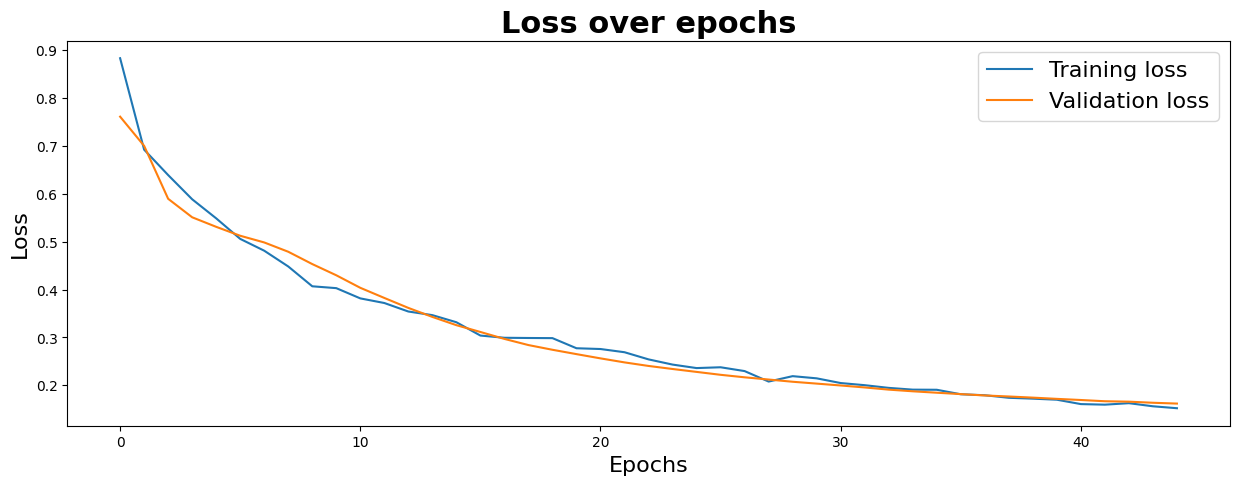

In [ ]:
 # Visualize loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs 

plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()

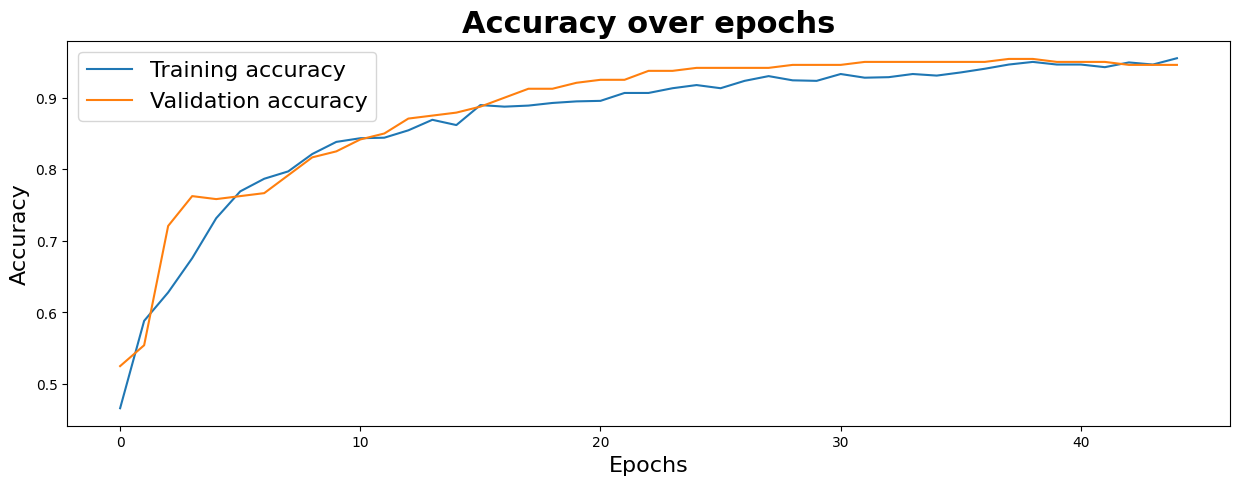

In [ ]:
# Visualize Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

---
At the end, we evaluate the model on the test set, plot the confusion matrix and calculate the f1-scores and the recall

13/13 [==============================] - 1s 75ms/step


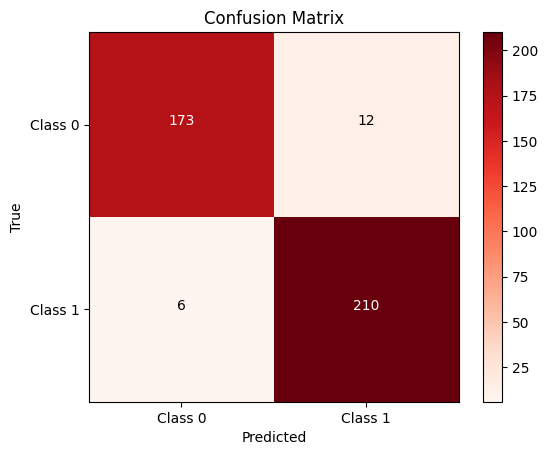

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       185
           1       0.95      0.97      0.96       216

    accuracy                           0.96       401
   macro avg       0.96      0.95      0.95       401
weighted avg       0.96      0.96      0.96       401



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)

predictions = model.predict(test_paths)

# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#Printing the accuracy, the f1-score and the recall for each class
predicted_probabilities = predictions.flatten()
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

report = classification_report(test_labels, predicted_labels)
print(report)

In [ ]:
#saving the model
model.save('/content/drive/MyDrive/models/CNN from scratch')